# Project: Predictors of Attendance Rates for Doctor Appointments in Brazil





## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project, I'll be analyzing data from 110,527 doctor visits that took place in Brazil between April 29, 2016 and June 8, 2016. To limit this to patients not reliant on parents/legal guardians for transportation, I've cut the dataset down to only
include patients ages 18 and older. I also removed people over the age of 100 since there were only 7 of them. With an age group
that small, it would be easy for the data for that age group to be thrown off. There were 46,045 patients with a total of 83,136
doctor visits that met this criteria.

Equipped the dataset, I'll be exploring how age, gender, and various health issues affect the likelihood of a 
patient showing up to their appointment. I'll also be looking to see how effective SMS reminders are and see if the time 
between the dates scheduled the and appointment dates have any effect on the rate of no-shows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
%matplotlib inline
sns.set_style('white')

<a id='wrangling'></a>
## Data Wrangling

This dataset was relatively clean to begin with, but there's a few changes that'll make analyzing this data easier. I'll start by loading the dataset from "noshowappointments-kagglev2-may-2016.csv" which Udacity originally sourced from Kaggle and taking a quick look at some basic properties of the dataset. 

### General Properties

__Load data from .csv file using pandas__

In [2]:
df_original = pd.read_csv('C:\\Users\\Ernest\\Desktop\\Coding\\Udacity\\Data Analyst Nanodegree\\Investigate a Dataset - Project 2\\Appointment No-shows\\noshowappointments-kagglev2-may-2016.csv')
df = df_original.copy()
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


I chose to load this data set and make a copy first so I could refer back to the original if I ever needed to.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


#### Now that my data is loaded, I'll make the following changes:
* Correct spelling of the 'Hipertension' & 'Handcap' column headers. 
* Standardize column formatting with all lowercase letters. 
* Change 'scheduledday' and 'appointmentday' to pandas datetime format.
* Remove 'appointmentid' column since the info it contains isn't useful.
* Create a column indicating whether or not the appointment date is within 7 days of when it was scheduled. I anticipate that appointments made within a short time frame (7 days) will have higher turnout.
* Create another column indicating whether or not the appointment date is within 1 day of when it was scheduled.
* Filter the data to only include patients older than 18 years old, but also less than 100 years old. This also removes the  patient with an age of -1. 
* Change 'patientid' column type to int64 to fix exponential formatting.
* Create age_group column to group by age.
* To minimize confusion, change 'no-show' column name to 'attended' and make the column's formatting binary like the other yes/no columns. A '1' indicates the patient attended, a '0' indicates they were a no-show. New column will be dtype int64. 

__Correct spelling of the 'Hipertension' & 'Handcap' column headers:__

In [4]:
df.rename(index=str, columns={"Hipertension": "hypertension", "Handcap": "handicap"}, inplace=True)

__Standardize column formatting with all lowercase letters:__

In [5]:
df.rename(columns=lambda x: x.strip().lower().replace(' ', '_'), inplace=True)
df.head(1)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


__Change 'scheduledday' and 'appointmentday' to pandas datetime format:__

In [6]:
df['scheduledday'] = pd.to_datetime(df['scheduledday'])
df['appointmentday'] = pd.to_datetime(df['appointmentday'])

__Remove 'appointmentid' column since the info it contains isn't useful:__

In [7]:
df.drop('appointmentid', axis=1, inplace=True)
df.head(1)

,patientid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no-show
0,2.987250e+13,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No


__Create a column indicating whether or not the appointment date is within 7 days of when it was scheduled:__

In [8]:
df.insert(4, 'scheduled_within_7_days', ((df.appointmentday - df.scheduledday) <= np.timedelta64(7, 'D')))

__Create another column indicating whether or not the appointment date is within 1 day of when it was scheduled:__

In [9]:
df.insert(4, 'scheduled_within_1_day', ((df.appointmentday - df.scheduledday) <= np.timedelta64(1, 'D')))

__Filter the data to only include patients older than 18 years old, but also less than 100 years old. This also removes the patient with an age of -1:__

In [10]:
df = df.query('100 > age >= 18').copy()

__Change 'patientid' column type to int64 to fix exponential formatting:__

In [11]:
df['patientid'] = df['patientid'].astype(np.int64)
df.head(1)

,patientid,gender,scheduledday,appointmentday,scheduled_within_1_day,scheduled_within_7_days,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no-show
0,29872499824296,F,2016-04-29 18:38:08,2016-04-29,True,True,62,JARDIM DA PENHA,0,1,0,0,0,0,No


__Create age_group column to group by age:__

In [12]:
bins = [18,29,39,49,59,69,79,89,99]
labels = ['18-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99']
age_group = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)
df.insert(7, 'age_group', age_group)
df.head(1)

,patientid,gender,scheduledday,appointmentday,scheduled_within_1_day,scheduled_within_7_days,age,age_group,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no-show
0,29872499824296,F,2016-04-29 18:38:08,2016-04-29,True,True,62,60-69,JARDIM DA PENHA,0,1,0,0,0,0,No


__Change 'no-show' column name to 'attended' and make the column's formatting binary like the other yes/no columns. A '1' 
indicates the patient attended, a '0' indicates they were a no-show. New column will be dtype int64:__

In [13]:
df.rename(index=str, columns={'no-show': 'attended'}, inplace=True)
yes_no_binary_flip = {'Yes':'0', 'No':'1'}
df['attended'].replace(yes_no_binary_flip, inplace=True)
df['attended'] = df['attended'].astype(np.int64)
df.head(1)

,patientid,gender,scheduledday,appointmentday,scheduled_within_1_day,scheduled_within_7_days,age,age_group,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,attended
0,29872499824296,F,2016-04-29 18:38:08,2016-04-29,True,True,62,60-69,JARDIM DA PENHA,0,1,0,0,0,0,1


<a id='eda'></a>
## Exploratory Data Analysis

In this section, I'll calculate the percent attendance for various groups and create visualizations with the goal of addressing questions posed in the Introduction section. 

_To reiterate, I'll be exploring how the following factors affect doctor appointment attendance rates:_
> * Age
> * Gender
> * Hypertension
> * Diabetes
> * Alchoholism
> * Disabilities
> * SMS Reminders

##### Useful functions
To simplify things, I've made 2 functions to help visualize the data. The first one, `Get_percentage()` returns a pandas series with the percentage of people that showed up to their appointments. `Chart_percentage()` takes the series generated from `Get_percentage()` and returns a bar or line chart.

In [14]:
def Get_percentage(grouped_by):
    '''
    Takes a pandas series (column) and returns another pandas series with the percentage of people from each group that attended 
    their appointment.
    '''
    percent_attendance = df.query('attended == "1"').groupby(grouped_by).attended.count() / \
                                                                                df.groupby(grouped_by).attended.count()
    percent_attendance = round((percent_attendance * 100), 2)
    return percent_attendance

In [15]:
def Chart_percentage(series, title, xlabel, ylabel, chart_type='bar', xticks_label=0):
    '''
    Takes a pandas series of percentages, a title, x and y labels.
    Returns a bar or line chart. 
    
    Parameters
    ----------
    chart_type : str
    - 'bar' : vertical bar plot (default)
    - 'line' : line plot
    
    xticks : sequence
        Values to use for the xticks
    '''
    if xticks_label == 0:
        xticks_label = series.index
    formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(formatter)
    ax = series.plot(kind=chart_type, alpha=0.8, figsize=(12,8))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 1, '{:1.2f}'.format(height), ha="center") 
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(range(len(series)), xticks_label, rotation='horizontal');

### How does age affect rate of attendance?

Use `Get_percentage('age_group')` to find the percentage of patients that attend by age group

In [16]:
age_group_percent_attended = Get_percentage('age_group')
age_group_percent_attended

age_group
18-29    75.35
30-39    78.25
40-49    79.73
50-59    82.50
60-69    84.93
70-79    84.80
80-89    84.22
90-99    79.80
Name: attended, dtype: float64

Use `Chart_percentage()` to plot attendance by age group

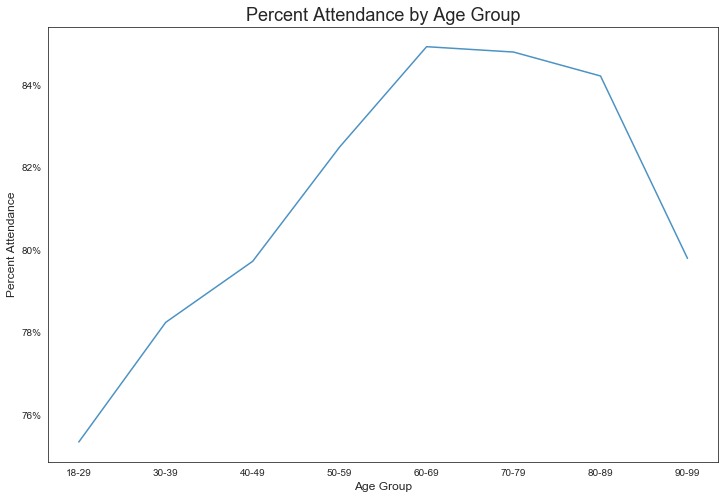

In [17]:
Chart_percentage(age_group_percent_attended, 'Percent Attendance by Age Group', 'Age Group', 'Percent Attendance', 'line')

Across all age groups, rate of attendance steadily increases until peaking for patients in their 60's. After peaking for 
patients in their 60's, the rate of attendance slowly tapers off in the 70's & 80's age groups before seeing a sharp drop-off
for those in their 90's. From this chart, one could reason that visiting a doctor becomes much more important as people age, but 
it's also becomes harder to get to the doctors once a certain age is hit.

### Are appointments scheduled by both genders equally?

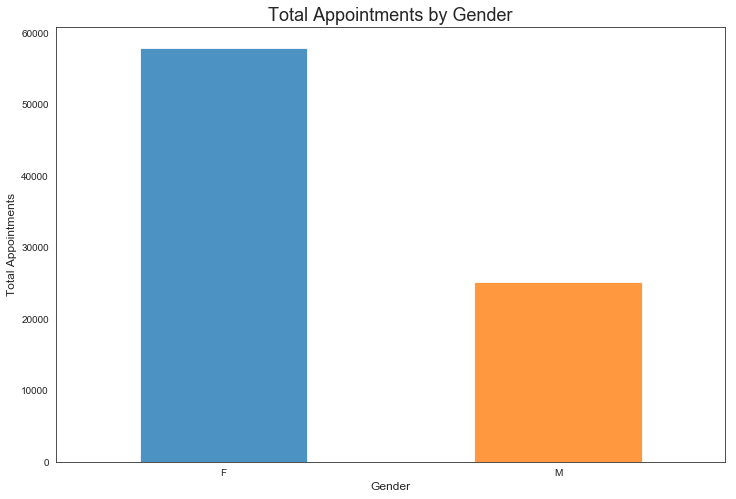

In [18]:
df['gender'].value_counts().plot(kind='bar', alpha=0.8, figsize=(12,8))
plt.title('Total Appointments by Gender', fontsize=18)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Total Appointments', fontsize=12)
plt.xticks(rotation='horizontal');

In [19]:
df.gender.value_counts()

F    57932
M    25204
Name: gender, dtype: int64

This wasn't one of the original questions I had, but I wanted to take a look at this data as it relates to my next question. To my surprise, women schedule more than double the appointments that men do. I would have guess that women are more health conscious than men, but the disparity between genders is much larger than I was expecting. In spite of this radical difference seen between men and women, I'd expect that males and females ages 18 and under would have a similar number of booked appointments since both genders are likely to be under their parents roof at that age.

In [20]:
df_original.query('Age <= 18').Gender.value_counts()

F    14955
M    13912
Name: Gender, dtype: int64

These numbers are much closer to what I would expect for adolescents, but females still have significantly more doctor appointments. To exclude most teen pregnancy related visits (which are high in Brazil), I'll take a look at the data for ages 16 and under.

In [21]:
df_original.query('Age <= 16').Gender.value_counts()

M    12994
F    12877
Name: Gender, dtype: int64

With the 16 and under age group, I've finally arived at figures that match my expectations. 

### How does gender affect rate of attendance?

Use `Get_percentage('gender')` to find the percentage of patitents that attend by gender

In [22]:
gender_percent_attended = Get_percentage('gender')
gender_percent_attended 

gender
F    80.1
M    81.0
Name: attended, dtype: float64

Use `Chart_percentage()` to plot attendance by gender.

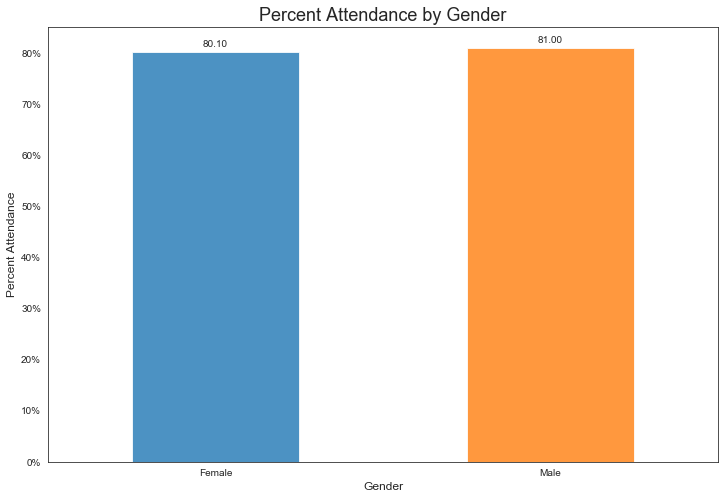

In [23]:
Chart_percentage(gender_percent_attended, 'Percent Attendance by Gender', 'Gender', 'Percent Attendance', xticks_label=['Female', 'Male'])

Since men booked much fewer appointments than women, one would expect that men would have a lower rate of attendance as well.
However, men and women had attendance rates that were roughly the same. In fact, men attended ~1% more of their appointments
than women did. You could reason that women book more doctor appointments because they have higher need for them. Some of this could definitely be attributed to pregnancy related visits, but it's very likely that the bulk of this difference is due to male and female attitudes towards doctors and seeking help in general.

### How does hypertension affect rate of attendance?

Use `Get_percentage('hypertension')` to find the percent attendance for patients with and without hypertension.

In [24]:
hypertension_percent_attended = Get_percentage('hypertension')
hypertension_percent_attended

hypertension
0    79.54
1    82.73
Name: attended, dtype: float64

Use `Chart_percentage()` to plot attendance of normal BP vs hypertension.

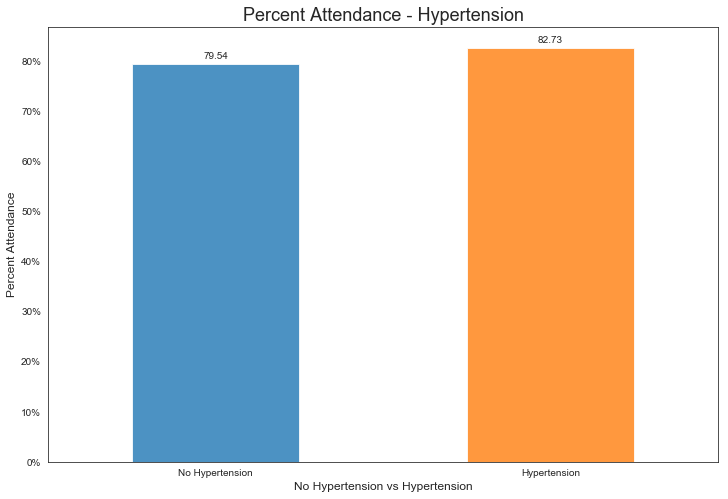

In [25]:
Chart_percentage(hypertension_percent_attended, 'Percent Attendance - Hypertension', 'No Hypertension vs Hypertension', \
      'Percent Attendance', xticks_label=['No Hypertension', 'Hypertension'])

The "Hypertension" group's rate of attendance isn't that much higher than the "No Hypertension" group, but you could guess that the rate is higher because they have a higher need for visiting a doctor. Healthy people without hypertension wouldn't need to
go to the doctor as much because they're generally in better shape.

### How does diabetes affect rate of attendance?

Use `Get_percentage('diabetes')` to find the percent attendance for patients with and without diabetes.

In [26]:
diabetes_percent_attended = Get_percentage('diabetes')
diabetes_percent_attended

diabetes
0    80.19
1    82.08
Name: attended, dtype: float64

Use `Chart_percentage()` to plot attendance of non-diabetics vs diabetics.

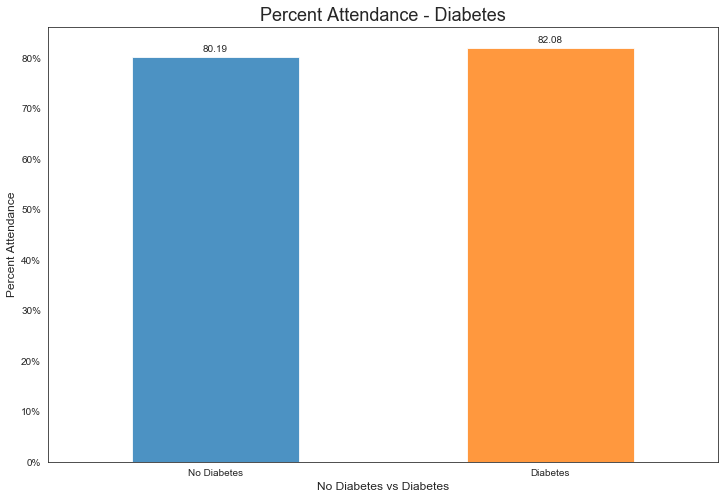

In [27]:
Chart_percentage(diabetes_percent_attended, 'Percent Attendance - Diabetes', 'No Diabetes vs Diabetes', 'Percent Attendance', xticks_label=['No Diabetes', 'Diabetes'])

Like the hypertension group, the higher rate of attendance for diabetics doesn't come as a surprise. It's more important for
them to make it to their appointments because there's more at stake for them than for the average healthy person.

### How does alcoholism affect rate of attendance?

Use `Get_percentage('alcoholism')` to find the percent attendance for patients with and without alcoholism.

In [28]:
alcoholism_percent_attended = Get_percentage('alcoholism')
alcoholism_percent_attended 

alcoholism
0    80.38
1    80.07
Name: attended, dtype: float64

Use `Chart_percentage()` to plot attendance of non-alcoholics vs alcoholics.

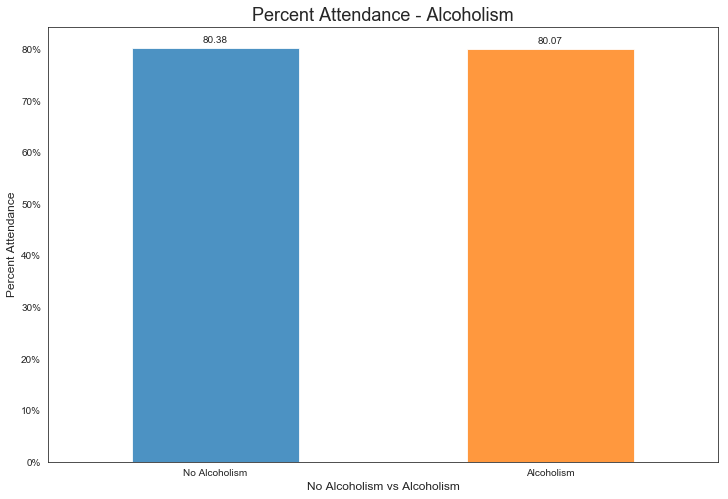

In [29]:
Chart_percentage(alcoholism_percent_attended, 'Percent Attendance - Alcoholism', 'No Alcoholism vs Alcoholism', 'Percent Attendance', xticks_label=['No Alcoholism', 'Alcoholism'])

In [30]:
df.alcoholism.value_counts()

0    79800
1     3336
Name: alcoholism, dtype: int64

These numbers are somewhat surprising. I would expect alcoholics to have a more difficult time getting to their doctor's
appointments, but the percent attendance is very close to that of non-alcoholics.

### How do disabilities affect rate of attendance?

Use `Get_percentage('handicap')` to find the percent attendance for patients having 0, 1, 2, 3, or 4 disabilities.

In [31]:
handicap_percent_attended = Get_percentage('handicap')
handicap_percent_attended

handicap
0     80.29
1     83.89
2     77.40
3     88.89
4    100.00
Name: attended, dtype: float64

Use `Chart_percentage()` to plot attendance of patients having 0, 1, 2, 3, or 4 disabilities.

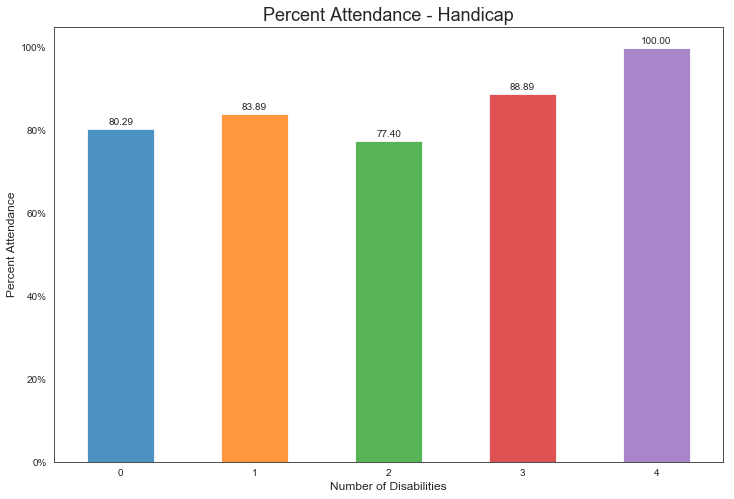

In [32]:
Chart_percentage(handicap_percent_attended, 'Percent Attendance - Handicap', 'Number of Disabilities', 'Percent Attendance')

It looks like attendance trends higher with more disabilities. This could be because people with multiple disabilities require
more medical attention. It could also be that people with more disabilities are more likely to have someone caring for them and taking them to their appointments. However, the 5th bar being 100% makes me a bit suspicious. To investigate, I'll check how many appointments there are in each group.

In [33]:
df.handicap.value_counts()

0    81136
1     1844
2      146
3        9
4        1
Name: handicap, dtype: int64

Unsurprisingly, there was only one appointment booked for people with 4 disabilities. There were also only 9 appointments for
the group with 3 disabilities. Since these low numbers could throw off our percentages, I'll combine the last 3 bars into a "2
or more" bar and re-plot the data.

In [34]:
df.handicap.replace({3:2, 4:2}, inplace=True)
df.handicap.value_counts()

0    81136
1     1844
2      156
Name: handicap, dtype: int64

Now I'll redo the bar chart and see if the upward trend still exists. 

In [35]:
modified_handicap_percent_attended = Get_percentage('handicap')
modified_handicap_percent_attended 

handicap
0    80.29
1    83.89
2    78.21
Name: attended, dtype: float64

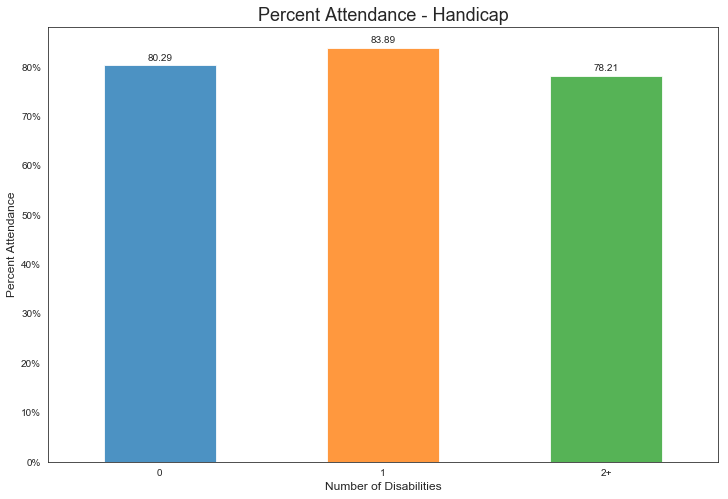

In [36]:
Chart_percentage(modified_handicap_percent_attended, 'Percent Attendance - Handicap', 'Number of Disabilities', 'Percent Attendance', xticks_label=['0', '1', '2+'])

This graph is likely a closer representation of reality. However, it would be a good idea to re-visit this question with a much
larger dataset to see if bars 4 and 5 actually do have higher rates of attendance. 

### How effective are text messages at improving the rate of attendance?

Use `Get_percentage('sms_received')` to find the percent attendance for patients that did or didn't receive a text reminder.

In [37]:
sms_received_percent_attended = Get_percentage('sms_received')
sms_received_percent_attended

sms_received
0    83.91
1    73.20
Name: attended, dtype: float64

Use `Chart_percentage()` to plot attendance of patients that did or didn't receive a text reminder.

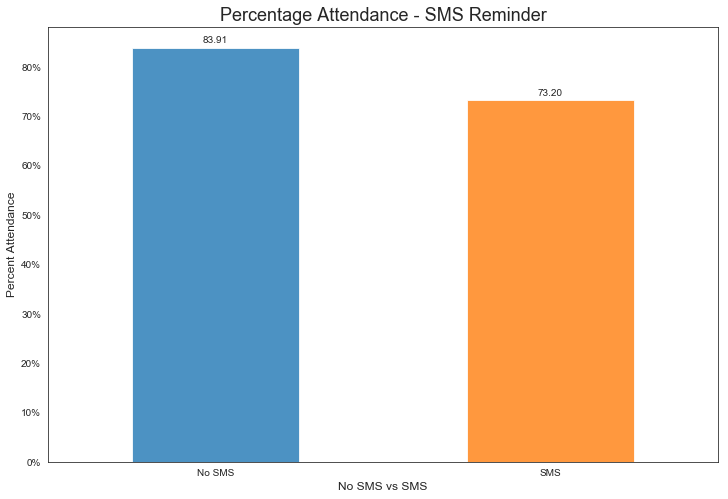

In [38]:
Chart_percentage(sms_received_percent_attended, 'Percentage Attendance - SMS Reminder', 'No SMS vs SMS', 'Percent Attendance', xticks_label=['No SMS', 'SMS'])

One would expect to see a higher attendance rate from those that received a text reminder. However, the graph above shows that
clearly wasn't the case when considering the entirety of the dataset. To understand why this could be, I considered what other
factors might correlate with not receiving a text reminder. The first thing that came to mind is that people that schedule 
same-day appointments wouldn't have a need for a text reminder. I would also expect same-day appointments to have a higher
attendance rate than those scheduled on a different day.

In [39]:
df.groupby('scheduled_within_1_day')['sms_received'].value_counts()

scheduled_within_1_day  sms_received
False                   1               27459
                        0               24226
True                    0               31451
Name: sms_received, dtype: int64

As suspected, same-day appointments didn't receive text reminders.

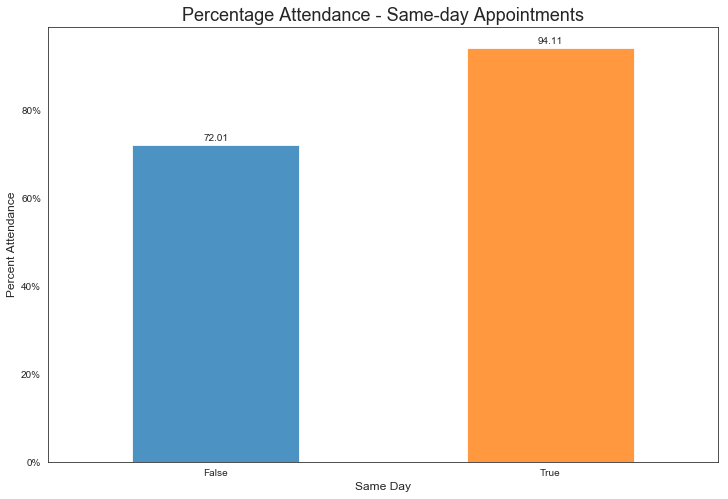

In [40]:
Chart_percentage(Get_percentage('scheduled_within_1_day'), "Percentage Attendance - Same-day Appointments", "Same Day", 'Percent Attendance')

Same-day appointments had a significantly higher attendance than appointments scheduled 2 or more days prior to the appointment. 
With 31,451 out of 83,136 appointments being same-day appointments, this throws off our data by a large margin. Now I'll exclude
same-day appointments and take another look.

In [41]:
sms_same_day_excluded_percent_attended = Get_percentage(df.query('scheduled_within_1_day == "0"')['sms_received'])
sms_same_day_excluded_percent_attended

sms_received
0.0    70.67
1.0    73.20
Name: attended, dtype: float64

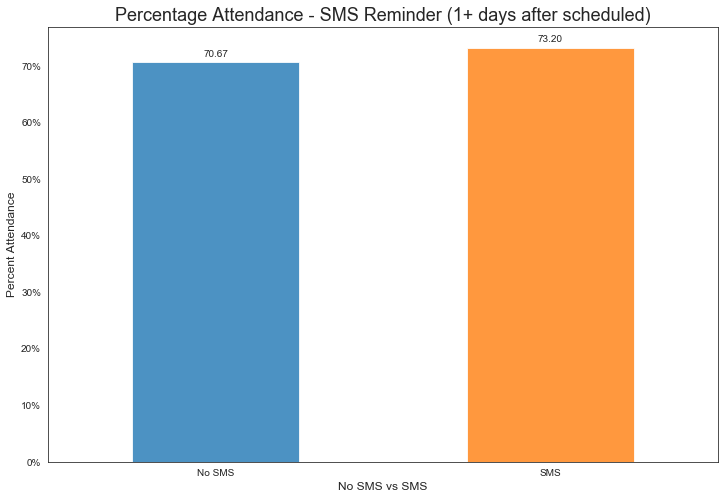

In [42]:
Chart_percentage(sms_same_day_excluded_percent_attended, 'Percentage Attendance - SMS Reminder (1+ days after scheduled)', 'No SMS vs SMS', 'Percent Attendance')
plt.xticks([0,1], ['No SMS', 'SMS']);

This chart aligns closer with what I was expecting, but let's take it a step further by excluding same-week appointments.

In [43]:
sms_same_week_excluded_percent_attended = Get_percentage(df.query('scheduled_within_7_days == "0"')['sms_received'])
sms_same_week_excluded_percent_attended

sms_received
0.0    65.62
1.0    71.40
Name: attended, dtype: float64

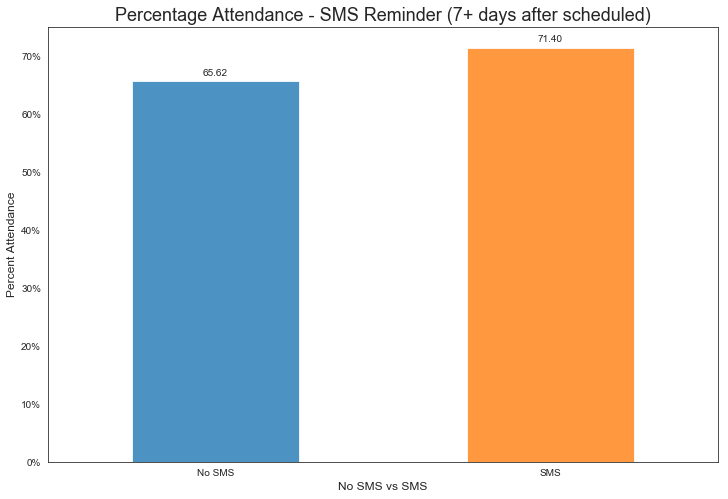

In [44]:
Chart_percentage(sms_same_week_excluded_percent_attended, 'Percentage Attendance - SMS Reminder (7+ days after scheduled)', 'No SMS vs SMS', 'Percent Attendance')
plt.xticks([0,1], ['No SMS', 'SMS']);

For patients that scheduled more than a week before their appointment, there was a significant increase of nearly 6% in the rate
of attendance for those that received a text reminder. A good idea for future analysis would be to collect data on not just whether or not someone received a text, but how many texts they received as well.

<a id='conclusions'></a>
## Conclusions

Despite a couple initial surprises like the one seen in the first SMS chart, there weren't any big shockers that I couldn't
think of possible reasons for. However, I still find the gap between the number of women's and men's appointments both 
surprising and worrisome. As a man, I oftentimes find myself researching my own health concerns instead of inquiring with a 
healthcare professional. I suspect that much of the difference seen in mortality rates of men and women could be attributed to this single issue. Next time I'm sick, I'm going to keep this in mind before dismissing the idea of seeing a doctor.

_A quick recommendation for healthcare providers:_
> Since you can't change the age, gender, or disabilities a person has and you can't force people to improve their hypertension, diabetes, or alcoholism through lifestyle changes, you should look to make changes to things you can control. Things like SMS and phone call reminders are a great place to start, but you should also be making use of your data to help identify patients at highest risk of not showing up for appointments. I would continue to collect data on the attributes of this dataset, but I'd also expand which data points are collected. With more data, you could build better predictions. With better predictions, you can save more money and help more people. 

Given more data over a longer time period, I'd like to explore how predictable individual behavior is over time. I'd expect the best predictor of all to be the individual patient's attendance history. 